### Imports & declarations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import *
import tensorflow as tf

LOCAL_PATH_MINI = '../data/raw/kaggle_mini_subsample'
LOCAL_PATH_TRAIN = '../data/raw/train'
COLAB_PATH_TRAIN = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/train'
COLAB_PATH_MINI = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/mini_subsample'
KAGGLE_PATH_TRAIN = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/'


RANDOM_STATE = 2020

# #Comment when running locally, uncomment for Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

### Define basic functions

In [2]:
def make_flat(x):
    s = x.shape
    dim_0 = s[0]
    dim_1 = s[1]*s[2]*s[3]
    x_flat = x.reshape(dim_0, dim_1)
    shape = (x_flat.shape[1],)
    return x_flat, shape

In [3]:
def plot_results(history, metrics=['accuracy'], val=True):
    
    for metric in metrics:
        x = range(len(history[metric]))

        plt.figure()
        plt.plot(x, history[metric], label='Train')

        if val == True:
            plt.plot(x, history['val_'+metric], label='Validation')
        plt.title(metric)
        plt.legend();

## Mini Dataset

#### Import & Clean

In [ ]:
# # TESTING TO GET LABEL ENCODING CORRECT
# path = KAGGLE_PATH_TRAIN
# data_tf = tf.keras.preprocessing.image_dataset_from_directory(path, 
#                                                 image_size=(32, 32),
#                                                 class_names=['NORMAL', 'PNEUMONIA'],
#                                                 seed=RANDOM_STATE)

# print('CLASS NAMES:', data_tf.class_names, 'CORRESPOND TO [0,1]')
# for i, item in enumerate(data_tf.as_numpy_iterator()):
#     if i == 0:
#         images = np.array(item[0])
#         labels = np.array(item[1])
#     else:
#         images = np.concatenate([images, item[0]], axis=0)
#         labels = np.concatenate([labels, item[1]], axis=0)
#         if i % 10 == 0:
#             print(int(i/(5232/BATCH_SIZE)*100), '%')

# images /= 256

# labels_inverted = np.array([0 if i == 1 else 1 for i in labels])
# labels = np.concatenate([labels_inverted.reshape(-1,1), labels.reshape(-1,1)], axis=1)


# # print('Data shape:', images.shape)
# # print('Label shape:', labels.shape)

In [ ]:
# BATCH_SIZE = 250
# TARGET_SIZE = [128, 128]

# path = COLAB_PATH_MINI
# image_generator = ImageDataGenerator().flow_from_directory(path, batch_size=BATCH_SIZE, target_size=TARGET_SIZE);
# images, labels = next(image_generator)
# images_scaled = images / 255

# display('Example image:', array_to_img(images[0]))
# print('Indices:', image_generator.class_indices)
# print('Dataset shape:', images_scaled.shape)

#### Mini Dataset Model

In [ ]:
# x, shape = make_flat(images_scaled)

# model = Sequential()
# model.add(Dense(32, activation='relu', input_shape = shape))
# model.add(Dense(2, activation='softmax'))
# model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

# history = model.fit(x=x, y=labels, epochs=50)

# plot_results(history.history, val=False)

# model.summary()

## Full Dataset

### Import and clean

In [4]:
path = KAGGLE_PATH_TRAIN
BATCH_SIZE = 32
data_tf = tf.keras.preprocessing.image_dataset_from_directory(path, 
                                                image_size=(64, 64), # Can work up to 256
                                                batch_size=BATCH_SIZE,
                                                class_names=['NORMAL', 'PNEUMONIA'],                                                
                                                seed=RANDOM_STATE)

print('CLASS NAMES:', data_tf.class_names, 'CORRESPOND TO [0,1]')

for i, item in enumerate(data_tf.as_numpy_iterator()):
    if i == 0:
        images = np.array(item[0])
        labels = np.array(item[1])
    else:
        images = np.concatenate([images, item[0]], axis=0)
        labels = np.concatenate([labels, item[1]], axis=0)
        if i % 10 == 0:
            print(int(i/(5232/BATCH_SIZE)*100), '%')

images /= 256

labels_inverted = np.array([0 if i == 1 else 1 for i in labels])
labels = np.concatenate([labels_inverted.reshape(-1,1), labels.reshape(-1,1)], axis=1)

data_tf = None # clear RAM
labels_inverted = None # clear RAM
print('Data shape:', images.shape)
print('Label shape:', labels.shape)

Found 5216 files belonging to 2 classes.
CLASS NAMES: ['NORMAL', 'PNEUMONIA'] CORRESPOND TO [0,1]
6 %
12 %
18 %
24 %
30 %
36 %
42 %
48 %
55 %
61 %
67 %
73 %
79 %
85 %
91 %
97 %
Data shape: (5216, 64, 64, 3)
Label shape: (5216, 2)


In [ ]:
# BATCH_SIZE_TRAIN = 1341+3875
# TARGET_SIZE = [256, 256]

# path = COLAB_PATH_TRAIN

# t0 = time.time()
# generator = ImageDataGenerator().flow_from_directory(path,
#                                                      #batch_size=BATCH_SIZE_TRAIN,
#                                                      target_size=TARGET_SIZE)

# images, labels = next(generator)
# images = images / 256
# t1 = time.time()

# print('Runtime:', t1-t0)
# print(images.shape, labels.shape)

CHANGE TERMINOLOGY TO FIRST SIMPLE MODEL, INSTEAD OF BASELINE. BASELINE IS RANDOM GUESS

Notes:
- Remove MSE

### Baseline Model

In [ ]:
x, shape = make_flat(images)

model = Sequential()
model.add(Dense(10, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')


history = model.fit(x=x, y=labels, 
                    epochs=100, 
                    verbose=1,
                    validation_split=0.25)

display(model.summary())


plot_results(history.history, ['accuracy', 'mse'])

### Define Callbacks

In [5]:
callbacks = [EarlyStopping(monitor='val_loss', patience=25),
             ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)]


### Entire train dataset, validation split

##### Create and fit model

In [ ]:
x, shape = make_flat(images)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy', 'mse'])

history = model.fit(x=x, y=labels, 
                    callbacks = callbacks,
                    epochs=500, 
                    validation_split=0.25, 
                    verbose=1)

#best_model = keras.models.load_model('best_model.h5')

In [ ]:
display(model.summary())

plot_results(history.history, ['accuracy', 'mse'])

### Create balanced dataset

### Create model with resampled dataset

### Add Regularization

In [ ]:
LAMBDA = 0.005
x, shape = make_flat(images)


model = Sequential()
model.add(Dense(256, activation='relu', input_shape = shape, kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

history = model.fit(x=x, y=labels, 
                    callbacks=callbacks, 
                    epochs=500, 
                    validation_split=0.25,
                    verbose=1)

plot_results(history.history, ['accuracy', 'mse'])

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

### Add Dropout

In [ ]:
x, shape = make_flat(images)


LAMBDA = 0.005
DROPOUT = 0.3

model = Sequential()
model.add(Dense(256, activation='relu', input_shape = shape, kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

history = model.fit(x=x, y=labels, 
                    callbacks=callbacks, 
                    epochs=500,
                    validation_split=0.25)

plot_results(history.history, ['accuracy', 'mse'])

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

### Remove the layer of 256 notes from previous model

In [ ]:
x, shape = make_flat(images)


LAMBDA = 0.005
DROPOUT = 0.3

model = Sequential()

model.add(Dense(64, activation='relu', input_shape = shape, kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

history = model.fit(x=x, y=labels, 
                    callbacks=callbacks, 
                    epochs=500,
                    validation_split=0.25)

plot_results(history.history, ['accuracy', 'mse'])

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

### Use Conv2D() instead of Dense() for first two layers

In [10]:
images.shape

(5216, 64, 64, 3)

In [11]:
labels.shape

(5216, 2)

In [12]:
LAMBDA = 0.005
DROPOUT = 0.3

model = Sequential()

#model.add(Conv2D(32, activation='relu', kernel_size=5, input_shape=images.shape, padding='same'))
model.add(Conv2D(6, activation='relu', kernel_size=5, padding='same'))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

Epoch 1/500
123/123 [==============================] - 5s 10ms/step - loss: 0.5187 - accuracy: 0.7726 - mse: 0.1669 - val_loss: 0.4451 - val_accuracy: 0.7952 - val_mse: 0.1453
Epoch 2/500
123/123 [==============================] - 1s 5ms/step - loss: 0.2646 - accuracy: 0.8974 - mse: 0.0794 - val_loss: 0.1825 - val_accuracy: 0.9248 - val_mse: 0.0553
Epoch 3/500
123/123 [==============================] - 1s 5ms/step - loss: 0.1796 - accuracy: 0.9342 - mse: 0.0514 - val_loss: 0.1540 - val_accuracy: 0.9425 - val_mse: 0.0452
Epoch 4/500
123/123 [==============================] - 1s 5ms/step - loss: 0.1456 - accuracy: 0.9445 - mse: 0.0419 - val_loss: 0.1497 - val_accuracy: 0.9456 - val_mse: 0.0438
Epoch 5/500
123/123 [==============================] - 1s 5ms/step - loss: 0.1353 - accuracy: 0.9462 - mse: 0.0390 - val_loss: 0.1304 - val_accuracy: 0.9502 - val_mse: 0.0373
Epoch 6/500
123/123 [==============================] - 1s 6ms/step - loss: 0.1351 - accuracy: 0.9481 - mse: 0.0389 - val_los

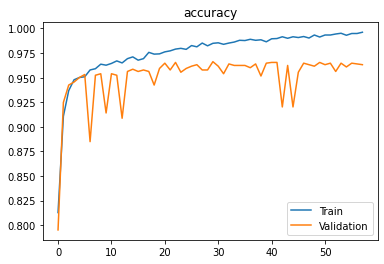

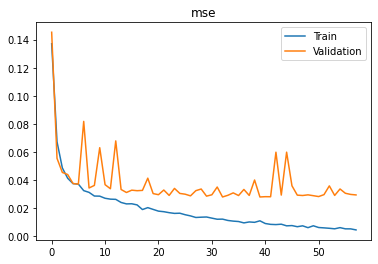

In [13]:
history = model.fit(x=images, y=labels, 
                    callbacks=callbacks, 
                    epochs=500,
                    validation_split=0.25)

plot_results(history.history, ['accuracy', 'mse'])

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

### Run top performing model on Test data

#### Import test data

In [ ]:
path = COLAB_PATH_TEST
BATCH_SIZE = 32
data_tf_test = tf.keras.preprocessing.image_dataset_from_directory(path, 
                                                image_size=(128, 128), # Can work up to 256
                                                batch_size=BATCH_SIZE,
                                                class_names=['NORMAL', 'PNEUMONIA'],                                                
                                                seed=RANDOM_STATE)

print('CLASS NAMES:', data_tf_test.class_names, 'CORRESPOND TO [0,1]')

for i, item in enumerate(data_tf_test.as_numpy_iterator()):
    if i == 0:
        images_test = np.array(item[0])
        labels_test = np.array(item[1])
    else:
        images_test = np.concatenate([images_test, item[0]], axis=0)
        labels_test = np.concatenate([labels_test, item[1]], axis=0)
        if i % 10 == 0:
            print(int(i/(5232/BATCH_SIZE)*100), '%')

images_test /= 256

labels_test_inverted = np.array([0 if i == 1 else 1 for i in labels_test])
labels_test = np.concatenate([labels_test_inverted.reshape(-1,1), labels_test.reshape(-1,1)], axis=1)

data_tf_test = None # clear RAM
print('Data shape:', images_test.shape)
print('Label shape:', labels_test.shape)

In [ ]:
best_model.evaluate(images_test, labels_test)